# GloVe Classifier

This is a version of the News Classifier that uses GloVe vectors for classification. GloVe vectors were downloaded from [here](https://nlp.stanford.edu/projects/glove/). The vectors are stored in the `data` folder of this repo, which is not commited to source code.

We implement two models in this notebook: the first uses a simple averaging of word vectors while the other uses a TF-IDF weighting of word vectors.

The weighted / non-weighted averaging of word embeddings is then passed into a logistic regression model for class prediction.

**Note: There are some random processes within this notebook, so different runs of the notebook may result in different outcomes.**

**Note: This notebook assumes the data being loaded has already been randomly shuffled.**

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from time import time
from torch.utils.data import BatchSampler, Dataset, DataLoader, SequentialSampler


## Load and Setup the Data

In [3]:
start_time = time()

data = pd.read_pickle('./data/train_data_glove.pickle')
labels = pd.read_pickle('./data/train_labels.pickle')
word_embeddings = pd.read_pickle('./data/embeddings.50d.pickle')

end_time = time()

print(f'Ran in {(end_time - start_time)/60:.02f}m.')


Ran in 0.69m.


In [4]:
# Since we are using the word embeddings provided,
# we can't make use of the __LOW_FREQ_TOKEN__ and
# __UNK__ tokens. Drop those columns.

data = data.drop(columns=['__LOW_FREQ_TOKEN__', '__UNK__'])


In [5]:
# Remove rows with no words.
non_zero_mask = data.sum(axis=1) != 0

data = data[non_zero_mask]
labels = labels[non_zero_mask]


In [6]:
word_encoder = {w:i for i,w in enumerate(word_embeddings.index)}
word_decoder = {i:w for w,i in word_encoder.items()}


In [7]:
# Will sort the columns in the data to match the
# encoding of the word embeddings. This will make
# things easier later on.

data = data[sorted(data.columns, key=lambda word: word_encoder[word])]


In [8]:
label_types = {l for l in labels}

label_encoder = {l:i for i, l in enumerate(label_types)}
label_decoder = {i:l for l, i in label_encoder.items()}


In [9]:
data = torch.LongTensor(data.values)
labels = torch.LongTensor([label_encoder[l] for l in labels])
embeddings = torch.FloatTensor(word_embeddings.values)


In [10]:
# The data is in bag-of-words format and our model expects a
# sequence of word indices. Need to convert the type here.

def bow_to_sequence(data_bow, encoder):
    """
    Converts a tensor using the bag-of-words data format to two
    tensors: the first tensor is a flat sequence of characters,
    the second tensor is a sequence of offsets to split the data on.
    
    Note that we are assuming the columns of data_bow
    match the indices of the encoder.
    """
    word_counts = data_bow.sum(axis=1)

    offsets = torch.zeros_like(word_counts, dtype=torch.int64)
    for i, count in enumerate(word_counts[:-1]):
        offsets[i+1] = offsets[i] + count
        
    sequence_len = word_counts.sum()
    sequence = torch.zeros(sequence_len, dtype=torch.int64)
    term_freqs = torch.zeros(sequence_len, dtype=torch.int64)

    non_zero_locations = torch.nonzero(data_bow)

    # Maps a word idx to the number of documents that index
    # shows up.
    doc_freq_map = {}

    # Note: This iteration assumes that non_zero_locations
    # has locations sorted by rows.
    iter = 0
    for location in non_zero_locations:
        row = location[0]
        col = location[1]
        freq = data_bow[row, col].item()

        if col.item() in doc_freq_map:
            doc_freq_map[col.item()] += 1
        else:
            doc_freq_map[col.item()] = 1

        for _ in range(freq):
            sequence[iter] = col
            term_freqs[iter] = freq
            iter +=1
    
    return sequence, offsets, term_freqs, doc_freq_map
    

In [11]:
start_time = time()

data_sequence, data_offsets, data_freqs, doc_freq_map = bow_to_sequence(data, word_encoder)

end_time = time()

print(f'Ran in {(end_time - start_time)/60:.02f}m.')


Ran in 15.04m.


## TF-IDF Weighting

TF-IDF weighting has been shown to out-perform a simple averaging of word vectors when passing them into a language model. Here, we calculate TF-IDF weighting of our words to generate weighted averages.

In [12]:
def calculate_tf_idf_weights(sequence, offsets, term_freqs, doc_freq_map):
    """
    Creates weights for sequences based on tf-idf weighting scheme.
    """
    n_docs = len(offsets)

    doc_freq_as_sequence = torch.FloatTensor([doc_freq_map[word_idx.item()] for word_idx in sequence])

    idf = torch.log(n_docs / doc_freq_as_sequence)

    tf_idf = term_freqs * idf
    
    # Need to normalize the weights so all samples add up to 1.
    offsets_with_end = torch.cat([offsets, torch.LongTensor([len(sequence)])])
    
    for i, offset in enumerate(offsets_with_end[:-1]):
        start = offset.item()
        end = offsets_with_end[i+1].item()
        
        weights = tf_idf[start:end]
        total_weight = torch.sum(weights)
        tf_idf[start:end] = weights / total_weight
        
    return tf_idf


In [13]:
def calculate_uniform_weights(sequence, offsets):
    """
    Creates uniform weighting scheme for words.
    """
    offsets_with_end = torch.cat([offsets, torch.LongTensor([len(sequence)])])

    weights = torch.zeros_like(sequence, dtype=torch.float32)

    for i, offset in enumerate(offsets_with_end[:-1]):
        start = offset.item()
        end = offsets_with_end[i+1].item()

        seq_len = end - start
        weights[start:end] = 1. / seq_len
        
    return weights
    

In [14]:
start_time = time()

uniform_weights = calculate_uniform_weights(data_sequence,
                                            data_offsets)

end_time = time()

print(f'Ran in {(end_time - start_time)/60:.02f}m.')


Ran in 0.02m.


In [15]:
start_time = time()

tf_idf_weights = calculate_tf_idf_weights(data_sequence,
                                          data_offsets,
                                          data_freqs,
                                          doc_freq_map)

end_time = time()

print(f'Ran in {(end_time - start_time)/60:.02f}m.')


Ran in 0.13m.


## Dataset and DataLoader

In [16]:
class DocDataset(Dataset):
    def __init__(self, sequence, offsets, labels, weights):
        self.sequence = sequence
        self.offsets = offsets
        self.labels = labels
        self.weights = weights


    def __len__(self):
        return len(self.offsets)


    def __getitem__(self, idx):
        offset = self.offsets[idx]

        if (idx + 1) < len(self):
            end = self.offsets[idx + 1]
            data_slice = slice(offset, end)
        else:
            data_slice = slice(offset)

        data = self.sequence[data_slice]
        weights = self.weights[data_slice]

        return {'data': data,
                'label': self.labels[idx],
                'offset': offset,
                'weights': weights}


    def all_samples(self):
        return {'data': self.sequence,
                'label': self.labels,
                'offset': self.offsets,
                'weights': self.weights}


In [17]:
def collate_samples(samples):
    """
    Samples are collated into a format that can be consumed
    more easily by the model. A sample has a data, label,
    offset key, which are combined into the same format.
    
    Note: This method assumes that samples are in
    sequential order.
    """
    data = torch.cat([s['data'] for s in samples])
    
    label = torch.LongTensor([s['label'].item() for s in samples])

    offset = torch.LongTensor([s['offset'].item() for s in samples])
    offset = offset - offset[0]
    
    weights = torch.cat([s['weights'] for s in samples])

    return {'data': data,
            'label': label,
            'offset': offset,
            'weights': weights}
    

In [18]:
# Split the data into training / validation sets.

train_fraction = 0.85
split_idx = math.floor(len(data_offsets) * train_fraction)

train_offsets = data_offsets[:split_idx]
valid_offsets = data_offsets[split_idx:]

train_sequence = data_sequence[:valid_offsets[0]]
valid_sequence = data_sequence[valid_offsets[0]:]

train_labels = labels[:split_idx]
valid_labels = labels[split_idx:]

train_uniform_weights = uniform_weights[:valid_offsets[0]]
valid_uniform_weights = uniform_weights[valid_offsets[0]:]

train_tf_idf_weights = tf_idf_weights[:valid_offsets[0]]
valid_tf_idf_weights = tf_idf_weights[valid_offsets[0]:]

# Need to re-calibrate the offsets of the validation set so
# the first offset points to the beginning of the
# validation sequence.
valid_offsets = valid_offsets - valid_offsets[0]


## Hyperparameter Configurations

In [198]:
# Doing a basic hyper-parameter grid search.

hyperparams_list = [
    { 'type': 'uniform', 'lr': 0.001,  'batch_size': 100, 'weights': (train_uniform_weights, valid_uniform_weights) },
    { 'type': 'uniform', 'lr': 0.01,   'batch_size': 100, 'weights': (train_uniform_weights, valid_uniform_weights) },
    { 'type': 'uniform', 'lr': 0.1,    'batch_size': 100, 'weights': (train_uniform_weights, valid_uniform_weights) },
    { 'type': 'uniform', 'lr': 0.001,  'batch_size': 10,  'weights': (train_uniform_weights, valid_uniform_weights) },
    { 'type': 'uniform', 'lr': 0.01,   'batch_size': 10,  'weights': (train_uniform_weights, valid_uniform_weights) },
    { 'type': 'uniform', 'lr': 0.1,    'batch_size': 10,  'weights': (train_uniform_weights, valid_uniform_weights) },
    { 'type': 'tf_idf',  'lr': 0.001,  'batch_size': 100, 'weights': (train_tf_idf_weights,  valid_tf_idf_weights)  },
    { 'type': 'tf_idf',  'lr': 0.01,   'batch_size': 100, 'weights': (train_tf_idf_weights,  valid_tf_idf_weights)  },
    { 'type': 'tf_idf',  'lr': 0.1,    'batch_size': 100, 'weights': (train_tf_idf_weights,  valid_tf_idf_weights)  },
    { 'type': 'tf_idf',  'lr': 0.001,  'batch_size': 10,  'weights': (train_tf_idf_weights,  valid_tf_idf_weights)  },
    { 'type': 'tf_idf',  'lr': 0.01,   'batch_size': 10,  'weights': (train_tf_idf_weights,  valid_tf_idf_weights)  },
    { 'type': 'tf_idf',  'lr': 0.1,    'batch_size': 10,  'weights': (train_tf_idf_weights,  valid_tf_idf_weights)  },    
]


## Create the Model

In [224]:
class Model(torch.nn.Module):
    def __init__(self, embeddings, n_classes):
        super(Model, self).__init__()

        self.embedding_bag = torch.nn.EmbeddingBag.from_pretrained(embeddings.clone(), mode='sum')
        self.linear = torch.nn.Linear(self.embedding_bag.embedding_dim, n_classes)
        
    def forward(self, input, offset, weights):
        if weights is not None:
            x = self.embedding_bag(input, offset, per_sample_weights=weights)
        else:
            x = self.embedding_bag(input, offset, per_sample_weights=weights)

        output = self.linear(x)
        return output
    
    def predict(self, input, offset, weights):
        with torch.no_grad():
            outputs = self(input, offset, weights)
            predictions = torch.argmax(outputs, axis=1)

        return predictions


## Training the Model

In [225]:
def train(model, criterion, optimizer, dataset, data_loader, epochs, log=True):
    train_losses = []

    for epoch in range(epochs):
        losses = []

        for batch in data_loader:
            data = batch['data']
            label = batch['label']
            offset = batch['offset']
            weights = batch['weights']

            optimizer.zero_grad()
            output = model(data, offset, weights)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            losses.append(loss)

        train_loss = torch.mean(torch.stack(losses))
        train_losses.append(train_loss)

        if log and (epoch + 1) % 10 == 0:
            samples = dataset.all_samples()
            predictions = model.predict(samples['data'], samples['offset'], samples['weights'])
            labels = samples['label']

            total = len(labels)
            correct = torch.sum(labels == predictions)

            print(f'Epoch {epoch + 1}')
            print(f'Accuracy: {float(correct)/total*100:.02f}%.')
            print(f'Training Loss: {train_loss.item()}')
            print()
        
    return train_losses
    

In [226]:
# Non-Weighted Model Training.

epochs = 20

models = []
train_losses_list = []
valid_losses = []

for i, hyperparams in enumerate(hyperparams_list):
    print(f'Starting training Model {i+1} / {len(hyperparams_list)}...')

    start_time = time()

    batch_size = hyperparams['batch_size']
    lr = hyperparams['lr']
    train_weights, valid_weights = hyperparams['weights']

    # 1. Setup Data Loader

    dataset = DocDataset(train_sequence, train_offsets, train_labels, train_weights)

    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             collate_fn=collate_samples)

    # 2. Create the Model

    model = Model(embeddings=embeddings, n_classes=len(label_types))

    # 3. Setup Criterion and Optimizer

    criterion = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 4. Train the Model

    train_losses = train(model,
                         criterion,
                         optimizer,
                         dataset,
                         data_loader,
                         epochs)
    
    # 5. Calculate Validation Loss
    
    with torch.no_grad():
        valid_dataset = DocDataset(valid_sequence, valid_offsets, valid_labels, valid_weights)
        valid_samples = valid_dataset.all_samples()

        outputs = model(valid_samples['data'], valid_samples['offset'], valid_samples['weights'])

        valid_loss = criterion(outputs, valid_labels)
        valid_losses.append(valid_loss)

    end_time = time()

    models.append(model)
    train_losses_list.append(train_losses)

    print(f'Model completed in {(end_time - start_time)/60:.02f}m.')
    print()


Starting training Model 1 / 2...
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
Epoch 10
Accuracy: 40.31%.
Training Loss: 2.180856227874756

done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
Epoch 20
Accuracy: 40.42%.
Training Loss: 2.17632794380188

Validation Accuracy: 40.31%.
Data:
tensor(18607.5410)
Model completed in 1.22m.

Starting training Model 2 / 2...
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
Epoch 10
Accuracy: 38.29%.
Training Loss: 2.3957784175872803

done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
done with epoch
Epoch 20
Accuracy: 38.38%.
Tra

## Check Results

In [227]:
uniform_mask = [hp['type'] == 'uniform' for hp in hyperparams_list]

uniform_models = [m for i, m in enumerate(models) if uniform_mask[i]]
uniform_train_losses_list = [losses for i, losses in enumerate(train_losses_list) if uniform_mask[i]]
uniform_valid_losses = [loss.item() for i, loss in enumerate(valid_losses) if uniform_mask[i]]

tf_idf_models = [m for i, m in enumerate(models) if not uniform_mask[i]]
tf_idf_train_losses_list = [losses for i, losses in enumerate(train_losses_list) if not uniform_mask[i]]
tf_idf_valid_losses = [loss.item() for i, loss in enumerate(valid_losses) if not uniform_mask[i]]


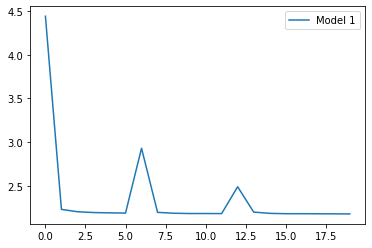

In [229]:
# Training loss of uniform models.

for i, model in enumerate(uniform_models):
    train_losses = uniform_train_losses_list[i]
    plt.plot(train_losses)

plt.legend([f'Model {i+1}' for i in range(len(uniform_models))])
plt.show()


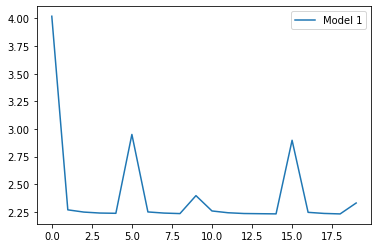

In [230]:
# Training loss of tf-idf models.

for i, model in enumerate(tf_idf_models):
    train_losses = tf_idf_train_losses_list[i]
    plt.plot(train_losses)

plt.legend([f'Model {i+1}' for i in range(len(tf_idf_models))])
plt.show()


### Find the Best Models

We will grab the "best" model trained on uniform weights and tf-idf weights. This will be based on which model scores the lowest validation loss.

In [231]:
# Grab the best models.

best_uniform_model_idx = uniform_valid_losses.index(min(uniform_valid_losses))
best_uniform_model = uniform_models[best_uniform_model_idx]

best_tf_idf_model_idx = tf_idf_valid_losses.index(min(tf_idf_valid_losses))
best_tf_idf_model = tf_idf_models[best_tf_idf_model_idx]

print(f'Best Uniform Model: {best_uniform_model_idx+1}')
print(f'Best TF-IDF Model:  {best_tf_idf_model_idx+1}')


Best Uniform Model: 1
Best TF-IDF Model:  1


### Accuracy

In [232]:
uniform_dataset = DocDataset(valid_sequence, valid_offsets, valid_labels, valid_uniform_weights)

uniform_samples = uniform_dataset.all_samples()

uniform_predictions = best_uniform_model.predict(uniform_samples['data'], uniform_samples['offset'], uniform_samples['weights'])

total = len(uniform_samples['label'])
correct = torch.sum(uniform_predictions == uniform_samples['label'])

print(f'Accuracy of Uniform Model: {(float(correct) / total)*100:.02f}%.')


Accuracy of Uniform Model: 40.31%.


In [235]:
tf_idf_dataset = DocDataset(valid_sequence, valid_offsets, valid_labels, valid_tf_idf_weights)

tf_idf_samples = tf_idf_dataset.all_samples()

tf_idf_predictions = best_tf_idf_model.predict(tf_idf_samples['data'], tf_idf_samples['offset'], tf_idf_samples['weights'])

total = len(tf_idf_samples['label'])
correct = torch.sum(tf_idf_predictions == tf_idf_samples['label'])

print(f'Accuracy of TF-IDF Model: {(float(correct) / total)*100:.02f}%.')


Accuracy of TF-IDF Model: 38.06%.


### Confusion Matrix

In [236]:
def create_confusion_matrix(labels, predictions):
    # Displaying a confusion matrix of the validation results for our model.

    categories = labels.unique()
    category_encoder = { c.item():i for i,c in enumerate(categories) }

    confusion_matrix = np.random.rand(len(categories), len(categories))

    for i, category in enumerate(categories):
        row = np.zeros(len(categories))

        cat_mask = (labels == category.item()).tolist()
        cat_preds = predictions[cat_mask]
        
        for category in categories:
            pred_count = torch.sum(cat_preds == category.item())
            row[category_encoder[category.item()]] = pred_count
            
        confusion_matrix[i, :] = row / len(cat_preds)

    return confusion_matrix, category_encoder


In [237]:
def show_confusion_matrix(confusion_matrix):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    cax = ax.matshow(confusion_matrix)

    fig.colorbar(cax)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    

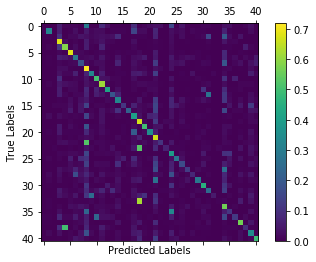

In [238]:
# Confusion Matrix for Uniform Model

uniform_confusion_matrix, category_encoder = create_confusion_matrix(valid_labels, uniform_predictions)
show_confusion_matrix(uniform_confusion_matrix)


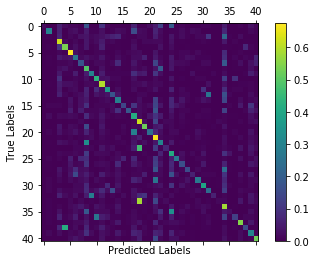

In [239]:
# Confusion Matrix for TF-IDF Model

tf_idf_confusion_matrix, category_encoder = create_confusion_matrix(valid_labels, tf_idf_predictions)
show_confusion_matrix(tf_idf_confusion_matrix)

## Persist Models

In [240]:
torch.save(best_uniform_model.state_dict(), './models/uniform_glove_model.torch')
torch.save(best_tf_idf_model.state_dict(), './models/tf_idf_model.torch')
